In [1]:
from model2 import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

%load_ext autoreload
%autoreload 2

In [45]:
df = pd.read_sql_query("""
                        SELECT latitude, 
                                longitude, 
                                ap_t_high100, 
                                n_arrests
                        FROM manhattan_loc_d_ar_wea 
                        ;"""
                        , 'postgresql:///walk')

In [46]:
df.describe()

,latitude,longitude,ap_t_high100,n_arrests
count,3.440040e+06,3.440040e+06,3.440040e+06,60430.000000
mean,4.077739e+01,-7.396711e+01,5.850189e+03,1.488251
std,4.462658e-02,2.698981e-02,2.107483e+03,1.374859
min,4.068300e+01,-7.404700e+01,-2.610000e+02,1.000000
25%,4.074300e+01,-7.398800e+01,4.074000e+03,1.000000
50%,4.077600e+01,-7.396800e+01,5.786000e+03,1.000000
75%,4.080500e+01,-7.394500e+01,7.559000e+03,2.000000
max,4.087900e+01,-7.390700e+01,1.014000e+04,87.000000


In [49]:
    categorized_df = categorize_arrests(df)

In [50]:
categorized_df.describe()

,latitude,longitude,ap_t_high100,n_arrests
count,3.440040e+06,3.440040e+06,3.440040e+06,3.440040e+06
mean,4.077739e+01,-7.396711e+01,5.850189e+03,1.756666e-02
std,4.462658e-02,2.698981e-02,2.107483e+03,1.313700e-01
min,4.068300e+01,-7.404700e+01,-2.610000e+02,0.000000e+00
25%,4.074300e+01,-7.398800e+01,4.074000e+03,0.000000e+00
50%,4.077600e+01,-7.396800e+01,5.786000e+03,0.000000e+00
75%,4.080500e+01,-7.394500e+01,7.559000e+03,0.000000e+00
max,4.087900e+01,-7.390700e+01,1.014000e+04,1.000000e+00


In [53]:
    # add combined lat/long location feature
    categorized_df['latlong'] = (categorized_df['latitude'].astype(str) 
                                + categorized_df['longitude'].astype(str))
    X_train, y_train, X_eval, y_eval = split_last(categorized_df, sort_col=None, cut=.8)

    

In [54]:
X_eval.describe()

,latitude,longitude,ap_t_high100
count,688008.000000,688008.000000,688008.000000
mean,40.777394,-73.967106,6601.403670
std,0.044627,0.026990,1346.445281
min,40.683000,-74.047000,3806.000000
25%,40.743000,-73.988000,5749.000000
50%,40.776000,-73.968000,6783.000000
75%,40.805000,-73.945000,7559.000000
max,40.879000,-73.907000,9330.000000


In [55]:
    column_transformer = ColumnTransformer( 
        transformers=[
        ('ohe', OneHotEncoder(categories='auto'), ['latlong']),
        ('ss', StandardScaler(), ['latitude', 'longitude', 'ap_t_high100'])],
        remainder='drop')

    

In [56]:
    # for max_feature in np.linspace():
    #     print(f"n_estimators = {n_estimators}")
    rfc = RandomForestClassifier(n_estimators=10, max_depth=10,
                            class_weight='balanced', max_features=None)

    pipe = Pipeline([
        ('preprocessor', column_transformer),
        ('model', rfc)
    ])

    # log_loss_cvs(pipe, X_train, y_train)

    

In [57]:
eval_probas = evaluate_model(pipe, X_train, y_train, X_eval, y_eval)

evaluating model
fitting model
model fit. Predicting for training set
training log loss: 0.5098131965744109
Predicting for evaluation set
test probabilities: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
test neg log loss: 0.5128030982665949
confusion matrix: 
[[474744 202107]
 [  2988   8169]]
accuracy: 0.7019002686015279
F1: 0.07378304046822289


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19f138240>,
      dtype=object)

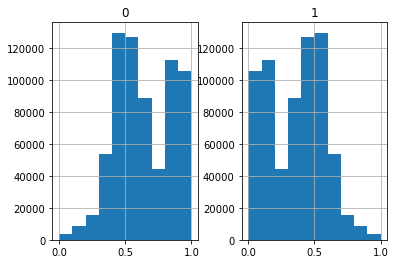

In [58]:
pd.DataFrame(eval_probas).hist()

In [ ]:
from sklearn.